<a href="https://colab.research.google.com/github/hyunholee26/Rainfall-Runoff-ML-basecode/blob/main/basemodel_rainfall_runoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rainfall - Runoff ML base model
 - 강우 - 유입량 관계를 예측하는 머신러닝 base code를 제공
 - 분석환경 : 구글 colab

## Step1. 파일 읽기

In [ ]:
# 구글 드라이브 연결 (파일을 불러오기 위해 필요)
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import datetime

In [3]:
# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

In [4]:
# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df = pd.read_csv(path + 'soyang.csv')
df

,OBSYMD,DAMCD,RF,IQTY
0,19740101,1012110,0.0000,10.000
1,19740102,1012110,0.0000,9.000
2,19740103,1012110,0.0000,4.800
3,19740104,1012110,0.0000,6.100
4,19740105,1012110,0.0000,5.800
...,...,...,...,...
15985,20171007,1012110,0.1613,6.583
15986,20171008,1012110,0.0000,26.463
15987,20171009,1012110,0.0000,6.836
15988,20171010,1012110,1.9319,19.367


In [ ]:
# 날짜 데이터 타입 변환
df['Date'] = df['OBSYMD'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d')) 
df

,OBSYMD,DAMCD,RF,IQTY,Date
0,19740101,1012110,0.0000,10.000,1974-01-01
1,19740102,1012110,0.0000,9.000,1974-01-02
2,19740103,1012110,0.0000,4.800,1974-01-03
3,19740104,1012110,0.0000,6.100,1974-01-04
4,19740105,1012110,0.0000,5.800,1974-01-05
...,...,...,...,...,...
15985,20171007,1012110,0.1613,6.583,2017-10-07
15986,20171008,1012110,0.0000,26.463,2017-10-08
15987,20171009,1012110,0.0000,6.836,2017-10-09
15988,20171010,1012110,1.9319,19.367,2017-10-10


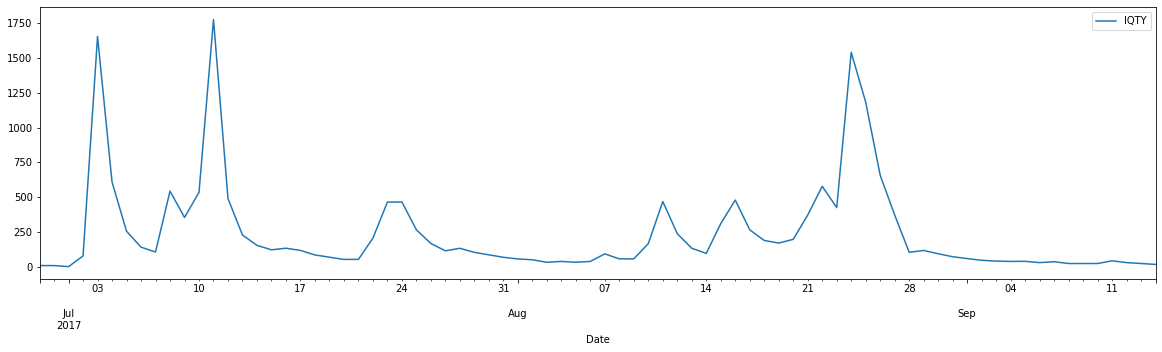

In [ ]:
# 2017년 7~9월 유입량 패턴 확인, 유입량 상승기가 2~3일 패턴 밖에 되지 않음을 확인
df[(df['OBSYMD'] > 20170628) & (df['OBSYMD'] < 20170915)][['Date', 'IQTY']].set_index('Date').plot(figsize = (20,5))

## Step 2. 데이터 전처리

In [10]:
# 시계열에 대한 Lag변수를 만들기 위한 함수
def buildLaggedFeatures(s,lag=2,dropna=True):

# Builds a new DataFrame to facilitate regressing over all possible lagged features
  if type(s) is pd.DataFrame:
    new_dict={}
    for col_name in s:
        new_dict[col_name]=s[col_name]
        # create lagged Series
        for l in range(1,lag+1):
            new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
    res=pd.DataFrame(new_dict,index=s.index)

  elif type(s) is pd.Series:
    the_range=range(lag+1)
    res=pd.concat([s.shift(i) for i in the_range],axis=1)
    res.columns=['lag_%d' %i for i in the_range]
  else:
    print('Only works for DataFrame or Series')
    return None
  if dropna:
    return res.dropna()
  else:
    return res 

In [14]:
# 강우에 대한 30일간의 Lag변수 생성
rf_30 = buildLaggedFeatures(df[['RF']],30)
rf_30

,RF,RF_lag1,RF_lag2,RF_lag3,RF_lag4,RF_lag5,RF_lag6,RF_lag7,RF_lag8,RF_lag9,RF_lag10,RF_lag11,RF_lag12,RF_lag13,RF_lag14,RF_lag15,RF_lag16,RF_lag17,RF_lag18,RF_lag19,RF_lag20,RF_lag21,RF_lag22,RF_lag23,RF_lag24,RF_lag25,RF_lag26,RF_lag27,RF_lag28,RF_lag29,RF_lag30
30,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
31,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
32,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
33,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
34,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,0.0830,0.0000,0.0000,0.0000,0.000,0.1049,0.2752,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,0.0000
15986,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,0.0830,0.0000,0.0000,0.000,0.0000,0.1049,0.2752,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000
15987,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,0.0830,0.0000,0.000,0.0000,0.0000,0.1049,0.2752,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000
15988,1.9319,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,0.0830,0.000,0.0000,0.0000,0.0000,0.1049,0.2752,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000


In [15]:
# 유입량에 대한 30일간의 Lag변수 생성

q_30 = buildLaggedFeatures(df[['IQTY']],30)
q_30

,IQTY,IQTY_lag1,IQTY_lag2,IQTY_lag3,IQTY_lag4,IQTY_lag5,IQTY_lag6,IQTY_lag7,IQTY_lag8,IQTY_lag9,IQTY_lag10,IQTY_lag11,IQTY_lag12,IQTY_lag13,IQTY_lag14,IQTY_lag15,IQTY_lag16,IQTY_lag17,IQTY_lag18,IQTY_lag19,IQTY_lag20,IQTY_lag21,IQTY_lag22,IQTY_lag23,IQTY_lag24,IQTY_lag25,IQTY_lag26,IQTY_lag27,IQTY_lag28,IQTY_lag29,IQTY_lag30
30,6.400,6.500,6.400,4.000,4.000,3.800,5.500,7.100,10.400,7.800,7.300,4.400,4.900,5.300,5.300,5.600,8.900,6.400,6.500,4.500,5.100,3.500,6.200,6.800,9.400,8.700,5.800,6.100,4.800,9.000,10.000
31,6.300,6.400,6.500,6.400,4.000,4.000,3.800,5.500,7.100,10.400,7.800,7.300,4.400,4.900,5.300,5.300,5.600,8.900,6.400,6.500,4.500,5.100,3.500,6.200,6.800,9.400,8.700,5.800,6.100,4.800,9.000
32,3.800,6.300,6.400,6.500,6.400,4.000,4.000,3.800,5.500,7.100,10.400,7.800,7.300,4.400,4.900,5.300,5.300,5.600,8.900,6.400,6.500,4.500,5.100,3.500,6.200,6.800,9.400,8.700,5.800,6.100,4.800
33,6.300,3.800,6.300,6.400,6.500,6.400,4.000,4.000,3.800,5.500,7.100,10.400,7.800,7.300,4.400,4.900,5.300,5.300,5.600,8.900,6.400,6.500,4.500,5.100,3.500,6.200,6.800,9.400,8.700,5.800,6.100
34,6.900,6.300,3.800,6.300,6.400,6.500,6.400,4.000,4.000,3.800,5.500,7.100,10.400,7.800,7.300,4.400,4.900,5.300,5.300,5.600,8.900,6.400,6.500,4.500,5.100,3.500,6.200,6.800,9.400,8.700,5.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,6.583,12.864,6.318,12.607,12.635,12.489,12.357,11.919,18.348,5.497,12.416,19.259,12.831,19.262,19.200,12.737,32.043,38.487,25.619,12.765,19.093,19.126,20.070,20.093,26.512,32.982,46.066,26.515,26.489,26.468,39.481
15986,26.463,6.583,12.864,6.318,12.607,12.635,12.489,12.357,11.919,18.348,5.497,12.416,19.259,12.831,19.262,19.200,12.737,32.043,38.487,25.619,12.765,19.093,19.126,20.070,20.093,26.512,32.982,46.066,26.515,26.489,26.468
15987,6.836,26.463,6.583,12.864,6.318,12.607,12.635,12.489,12.357,11.919,18.348,5.497,12.416,19.259,12.831,19.262,19.200,12.737,32.043,38.487,25.619,12.765,19.093,19.126,20.070,20.093,26.512,32.982,46.066,26.515,26.489
15988,19.367,6.836,26.463,6.583,12.864,6.318,12.607,12.635,12.489,12.357,11.919,18.348,5.497,12.416,19.259,12.831,19.262,19.200,12.737,32.043,38.487,25.619,12.765,19.093,19.126,20.070,20.093,26.512,32.982,46.066,26.515


In [19]:
# 30일간의 lag된 강우와, 30일째 유입량을 변수로 만듬
# RF(t) ~ RF(t-30)으로  Q(t)를 예측하는 문제로 설정함
data = pd.concat([rf_30, q_30['IQTY']], axis=1)
data = data.reset_index(drop=True)
data

,RF,RF_lag1,RF_lag2,RF_lag3,RF_lag4,RF_lag5,RF_lag6,RF_lag7,RF_lag8,RF_lag9,RF_lag10,RF_lag11,RF_lag12,RF_lag13,RF_lag14,RF_lag15,RF_lag16,RF_lag17,RF_lag18,RF_lag19,RF_lag20,RF_lag21,RF_lag22,RF_lag23,RF_lag24,RF_lag25,RF_lag26,RF_lag27,RF_lag28,RF_lag29,RF_lag30,IQTY
0,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.400
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.300
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.800
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.300
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15955,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,0.0830,0.0000,0.0000,0.0000,0.000,0.1049,0.2752,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,0.0000,6.583
15956,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,0.0830,0.0000,0.0000,0.000,0.0000,0.1049,0.2752,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,26.463
15957,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,0.0830,0.0000,0.000,0.0000,0.0000,0.1049,0.2752,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,6.836
15958,1.9319,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,0.0830,0.000,0.0000,0.0000,0.0000,0.1049,0.2752,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,19.367


In [20]:
# train dataset과 test dataset으로 분리
train = data[:15000]
test = data[15000:]

In [21]:
# 사용할 머신러닝 알고리즘 import

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


In [24]:
# 독립변수와 종속변수 분리

X_train = train.drop(['IQTY'], axis = 1)
y_train = train['IQTY']
X_test = test[X_train.columns]
y_test = test['IQTY']

# Step 3. 머신러닝 훈련 및 예측

In [29]:
# 선형회귀에 대한 예측

m = LinearRegression()
m.fit(X_train,y_train)
pred=m.predict(X_test)
r2=r2_score(y_test.to_numpy(), pred)
r2

0.6884932592899007

In [32]:
# 선형회귀, Lasso, Ridge, SVR, Randomforest, LGBM 모델을 설정하고, 위와 동일하게 반복 수행하며
# test dataset에 대한 r-squared 계산

models=[LinearRegression(), 
        Lasso(random_state=0), 
        Ridge(random_state=0),
        SVR(kernel='poly', degree = 2), 
        RandomForestRegressor(random_state=0), 
        LGBMRegressor(random_state=0)]
     
model_names=['LinearRegression',
             'Lasso', 
             'Ridge',
             'SVR_poly',
             'RandomForestRegressor',
             'LGBMRegressor']

r2_list=[]

for model in range (len(models)):
  print(model_names[model])
  clf=models[model]
  clf.fit(X_train,y_train)
  pred=clf.predict(X_test)
  r2=r2_score(y_test.to_numpy(), pred)
  print(r2)
  r2_list.append(r2)
  

LinearRegression
0.6884932592899007
Lasso
0.6887537266432107
Ridge
0.6884933422589641
SVR_poly
0.8029670669184789
RandomForestRegressor
0.8615841731372769
LGBMRegressor
0.8268635759935792


In [34]:
print(r2_list)

[0.6884932592899007, 0.6887537266432107, 0.6884933422589641, 0.8029670669184789, 0.8615841731372769, 0.8268635759935792]
